# 1. Описание задачи рекоммендации

В дополнение к основной задаче поставлена другая задача - нужно создать список типов, например из десяти доступных, из которого селлер выберет подходящий.


# 2. Загрузка и подготовка данных.

In [ ]:
import numpy as np
import pandas as pd
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn import metrics
from sklearn.metrics import roc_auc_score
from sklearn.metrics import classification_report
import seaborn as sns
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from sklearn.preprocessing import LabelEncoder, StandardScaler

In [ ]:
data_test = pd.read_parquet('hackaton_test_types_recom.parquet')
data_train = pd.read_parquet('hackaton_train_types_recom.parquet')
print(f'data_train: {data_train.shape}')
print(f'data_test: {data_test.shape}')

data_train: (763013, 8)
data_test: (190754, 8)


In [ ]:
data_train.head()

,main_photo,name,type,category_l2,category_l4,is_markup,target,stratify_column
6762112,https://cdn1.ozone.ru/s3/multimedia-d/65647598...,Фильтр АКПП HYUNDAI GETZ 02-10/ELANTRA 1.8 00-...,Ремкомплект двигателя мототехники,None,None,False,0,nan_False_0
2248350,https://cdn1.ozone.ru/s3/multimedia-r/67002690...,"Масло оливковое Urzante Light рафинированное, ...",Растительное масло,None,None,False,1,nan_False_1
2940012,https://cdn1.ozone.ru/multimedia/1026904772.jpg,Свитшот Reebok Cl A Crew,Оповещатель,None,None,False,0,nan_False_0
7671340,https://cdn1.ozone.ru/s3/multimedia-1-r/700080...,Клин съемник для снятия пластика в авто,Съемник,None,None,False,1,nan_False_1
795605,https://cdn1.ozone.ru/s3/multimedia-1-u/712028...,HXD Пыльник,Олимпийка,None,None,False,0,nan_False_0


In [ ]:
data_test = data_test.drop(labels=['main_photo', 'stratify_column'], axis=1).reset_index(drop=True)
data_train = data_train.drop(labels=['main_photo', 'stratify_column'], axis=1).reset_index(drop=True)
print(f'data_train: {data_train.shape}')
print(f'data_test: {data_test.shape}')

data_train: (763013, 6)
data_test: (190754, 6)


In [ ]:
data_train['is_markup'] = data_train['is_markup'].astype(int)
data_test['is_markup'] = data_test['is_markup'].astype(int)

---

#### 1 вариант - удалить пропуски

In [ ]:
# Функция для удаления пропусков / аномалий
def remove__missing(df, column, errors):
    cleaned = df[column].astype(str).str.strip().str.lower()
    return df[~cleaned.isin(errors)].reset_index(drop=True)

In [ ]:
# Применение:
errors = ['0', '1', 'unknown', 'none', 'null', 'nan', 'n/a', 'na', 'missing', '?', ' ', '-', '', '...', 'неизвестно']
before_train, before_test = data_train.shape[0], data_test.shape[0]
for category in ['name', 'type', 'category_l2', 'category_l4']:
    data_train = remove__missing(data_train, category, errors)
    data_test = remove__missing(data_test, category, errors)
print(f'data_train: {data_train.shape} - теряем {((before_train - data_train.shape[0]) / before_train) * 100:.2f}% информации')
print(f'data_test:  {data_test.shape} - теряем {((before_test - data_test.shape[0]) / before_test) * 100:.2f}% информации')

data_train: (442365, 6) - теряем 42.02% информации
data_test:  (110598, 6) - теряем 42.02% информации


In [ ]:
data_test.head(2)

,name,type,category_l2,category_l4,is_markup,target
0,Кружка латте керамическая большая для чая и ко...,Кружка,Дом и сад,Кружка,0,1
1,"Угольник-переходник ROMMER ВПр-НР, 15х1_2, из ...",Удлинитель сантехнический,Строительство и ремонт,Фитинг сантехнический,1,1


In [ ]:
data_train.head(2)

,name,type,category_l2,category_l4,is_markup,target
0,Кроссовки Air Jordan JT 2 Баскетбольная обувь ...,Моноласта,Обувь,Кроссовки,1,0
1,Подвесной держатель для медалей,Стеллаж для игрушек,Дом и сад,Ящик для игрушек,1,0


---

#### 2 вариант - заменить на 'unknown'

In [ ]:
# # Функция для замены пропусков / аномалий на 'unknown'
# def replace__missing(df, column, errors):
#     df[column] = df[column].astype(str).str.strip().str.lower().apply(lambda x: 'unknown' if x in errors else x)
#     return df

In [ ]:
# # Применение:
# errors = ['0', '1', 'unknown', 'none', 'null', 'nan', 'n/a', 'na', 'missing', '?', ' ', '-', '', '...', 'неизвестно']
# for category in ['name', 'type', 'category_l2', 'category_l4']:
#     data_train = replace__missing(data_train, category, errors)
#     data_test = replace__missing(data_test, category, errors)
# print(f'data_train: {data_train.shape}')
# print(f'data_test:  {data_test.shape}')

In [ ]:
# data_train.head(2)

In [ ]:
# data_test.head(2)

---

In [ ]:
y_train = data_train['target']
X_train = data_train.drop(columns=['target'])
y_test = data_test['target']
X_test = data_test.drop(columns=['target'])
print(f'X_train: {X_train.shape}')
print(f'X_test:  {X_test.shape}')
print(f'y_train: {y_train.shape}')
print(f'y_test:  {y_test.shape}')

X_train: (442365, 5)
X_test:  (110598, 5)
y_train: (442365,)
y_test:  (110598,)


In [ ]:
# Создаём объект TF-IDF векторизатора
# TF-IDF по name → числовая матрица
# - max_features=500 — используем только 500 наиболее важных слов/фраз (признаков),
# - ngram_range=(1, 2) — учитываем отдельные слова (1) и пары слов (2).
vectorizer = TfidfVectorizer(max_features=500, ngram_range=(1, 2))

# Обучаем векторизатор на столбце 'name' и преобразуем его в числовую матрицу признаков - она будет спарс-матрица с кучей ноликов
# Каждая строка — это один объект (товар), каждая колонка — один признак (слово или пара слов)
text_train = vectorizer.fit_transform(X_train['name'])
text_test = vectorizer.transform(X_test['name'])

In [ ]:
# CatBoost не принимает sparse матрицы, а TF-IDF — sparse
# TF-IDF в DataFrame
text_train_df = pd.DataFrame(text_train.toarray(), columns=[f'tfidf_{i}' for i in range(text_train.shape[1])])
text_test_df = pd.DataFrame(text_test.toarray(), columns=[f'tfidf_{i}' for i in range(text_test.shape[1])])

In [ ]:
# Сброс индексов
text_train_df.reset_index(drop=True, inplace=True)
text_test_df.reset_index(drop=True, inplace=True)
X_train = X_train.drop(labels='name', axis=1).reset_index(drop=True)
X_test = X_test.drop(labels='name', axis=1).reset_index(drop=True)

# Объединение
X_train_full = pd.concat([text_train_df, X_train], axis=1)
X_test_full = pd.concat([text_test_df, X_test], axis=1)

In [ ]:
# будут потом для теста качества с новыми фичами
X_train_full_new = X_train_full.copy()
X_test_full_new = X_test_full.copy()

In [ ]:
X_train_full.head()

,tfidf_0,tfidf_1,tfidf_2,tfidf_3,tfidf_4,tfidf_5,tfidf_6,tfidf_7,tfidf_8,tfidf_9,...,tfidf_494,tfidf_495,tfidf_496,tfidf_497,tfidf_498,tfidf_499,type,category_l2,category_l4,is_markup
0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Моноласта,Обувь,Кроссовки,1
1,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Стеллаж для игрушек,Дом и сад,Ящик для игрушек,1
2,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Кроссовки,Обувь,Кроссовки,0
3,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Набор для приготовления настойки,Продукты питания,"Смесь приправ, специй и трав",1
4,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,Багажный бокс (автобокс),Автотовары,Багажный бокс (автобокс),1


In [ ]:
# разделение тренировочных данные на тренировочную и валидационную
from sklearn.model_selection import train_test_split

X_train_part, X_val, y_train_part, y_val = train_test_split(
    X_train_full, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f'X_train_part: {X_train_part.shape}')
print(f'X_val:  {X_val.shape}')
print(f'y_train_part: {y_train_part.shape}')
print(f'y_val:  {y_val.shape}')

X_train_part: (353892, 504)
X_val:  (88473, 504)
y_train_part: (353892,)
y_val:  (88473,)


In [ ]:
# Cat_boost сам кодирует категории
cat_features = ['type', 'category_l2', 'category_l4']

from catboost import CatBoostClassifier

model = CatBoostClassifier(
    iterations=300,         # число деревьев (иттераций бустинга)
    learning_rate=0.1,      # шаг обучения
    depth=6,                # максимальная глубина деревьев
    verbose=100,             # вывод информации каждые 100 итераций
    loss_function='Logloss',  # функция потерь для бинарной классификации
    eval_metric='AUC'         # метрика качества для валидации — ROC AUC
)

In [ ]:
model.fit(
    X_train_part,       # матрица признаков
    y_train_part,            # целевой признак (0/1)
    cat_features=cat_features,         # категориальные признаки
    eval_set=(X_val, y_val)     # валидационный набор для контроля переобучения и оценки ROC AUC
)

0:	test: 0.9001061	best: 0.9001061 (0)	total: 433ms	remaining: 2m 9s
100:	test: 0.9851687	best: 0.9851687 (100)	total: 18.5s	remaining: 36.5s
200:	test: 0.9855628	best: 0.9855628 (200)	total: 35.5s	remaining: 17.5s
299:	test: 0.9857263	best: 0.9857263 (299)	total: 54.4s	remaining: 0us

bestTest = 0.9857262625
bestIteration = 299



Лучшая AUC на валидации: 0.9857

In [ ]:
# Предсказание вероятности класса 1 (target = 1)
preds_proba = model.predict_proba(X_test_full)[:, 1]
preds = model.predict(X_test_full)

In [ ]:
roc_auc = roc_auc_score(y_test, preds_proba)
print(f"ROC-AUC на тесте: {roc_auc:.4f}")
print()
print(classification_report(y_test, preds))

ROC-AUC на тесте: 0.9860

              precision    recall  f1-score   support

           0       0.90      0.93      0.92     38648
           1       0.96      0.95      0.95     71950

    accuracy                           0.94    110598
   macro avg       0.93      0.94      0.94    110598
weighted avg       0.94      0.94      0.94    110598



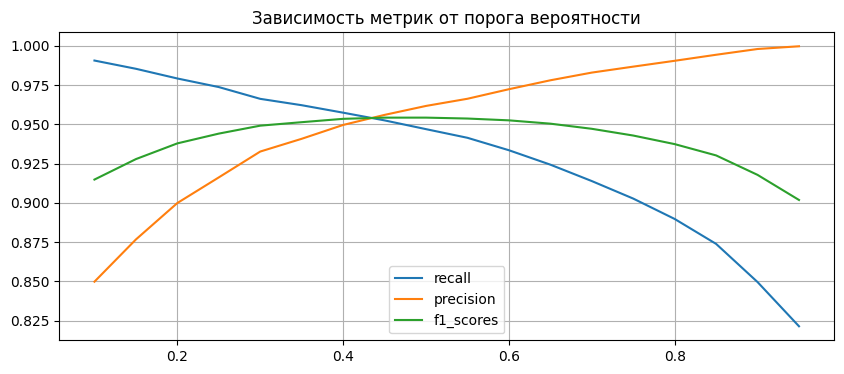

In [ ]:
# Порог принятия решений

# списки, в которых будут значения метрик
recall_scores = []
precision_scores = []
f1_scores = []

# набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле перебирать пороги
for threshold in thresholds:
    preds = (preds_proba > threshold).astype(int)

    recall_scores.append(metrics.recall_score(y_test, preds))
    precision_scores.append(metrics.precision_score(y_test, preds))
    f1_scores.append(metrics.f1_score(y_test, preds))

fig = plt.figure(figsize=(10, 4))
sns.lineplot(x=thresholds, y=recall_scores, label='recall')
sns.lineplot(x=thresholds, y=precision_scores, label='precision')
sns.lineplot(x=thresholds, y=f1_scores, label='f1_scores')
plt.title('Зависимость метрик от порога вероятности')
plt.legend()
plt.grid(True)
plt.show()

Выбираем порог 0.45 - на пересечении метрик

In [ ]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.45
preds_opt = (preds_proba >= threshold_opt).astype('int')
print(classification_report(y_test, preds_opt))

              precision    recall  f1-score   support

           0       0.91      0.92      0.92     38648
           1       0.96      0.95      0.95     71950

    accuracy                           0.94    110598
   macro avg       0.93      0.94      0.93    110598
weighted avg       0.94      0.94      0.94    110598



практически одинаковые метрики при порогах 0.5 и 0.45

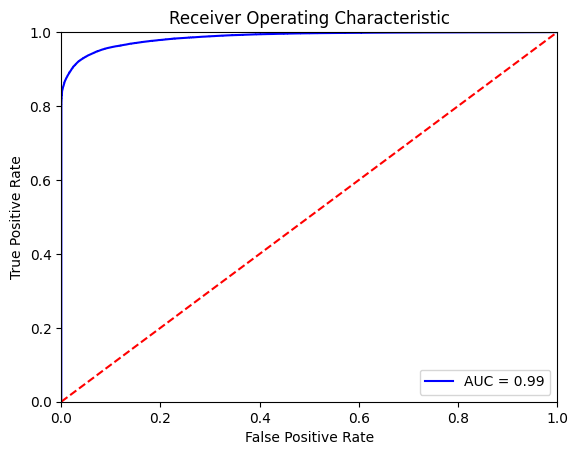

In [ ]:
# Строим ROC кривую из статистики)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_proba)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

Добавить фичи:

- len_name — длина строки в столбце name (количество символов)
- len_type — длина строки в столбце type
- len_category_l2 — длина строки в столбце category_l2
- len_category_l4 — длина строки в столбце category_l4
- n_words_name — количество слов в name
- n_words_type — количество слов в type
- n_category_l2 — количество слов в category_l2
- n_category_l4 — количество слов в category_l4
- type_in_name — бинарный флаг, равный 1, если значение type встречается внутри строки name, иначе 0
- common_words_name_type — количество общих слов между name и type
- unknown_flag — бинарный флаг, равный 1, если в category_l2 стоит значение 'unknown', иначе 0 (при варианте 1 нет смысла - только при варианте 2). В функции ниже его нет, но можно дописать, если вдруг надумаем

In [ ]:
print(X_train_full_new.shape)
print(X_test_full_new.shape)

(442365, 504)
(110598, 504)


In [ ]:
# CatBoost вроде как устойчив к масштабированию - там же деревья, поэтому можем не стандартизовывать / нормализовывать
# добавляем новые вичи функцией

X_train_full_new['name'] = data_train['name']
X_test_full_new['name'] = data_test['name']

def add_text_features(df):
    df['len_name'] = df['name'].astype(str).str.len()
    df['len_type'] = df['type'].astype(str).str.len()
    df['len_category_l2'] = df['category_l2'].astype(str).str.len()
    df['len_category_l4'] = df['category_l4'].astype(str).str.len()

    df['n_words_name'] = df['name'].astype(str).str.split().apply(len)
    df['n_words_type'] = df['type'].astype(str).str.split().apply(len)
    df['n_words_category_l2'] = df['category_l2'].astype(str).str.split().apply(len)
    df['n_words_category_l4'] = df['category_l4'].astype(str).str.split().apply(len)

    df['type_in_name'] = df.apply(
        lambda row: int(str(row['type']).lower() in str(row['name']).lower()),
        axis=1
    )

    df['common_words_name_type'] = df.apply(
        lambda row: len(set(str(row['name']).lower().split()) & set(str(row['type']).lower().split())),
        axis=1
    )

# Применим к обучающему и тестовому датасету
add_text_features(X_train_full_new)
add_text_features(X_test_full_new)

# Теперь удаляем name из датафреймов
X_train_full_new.drop(labels='name', axis=1, inplace=True)
X_test_full_new.drop(labels='name', axis=1, inplace=True)


In [ ]:
print(X_train_full_new.shape)
print(X_test_full_new.shape) # + 10 фичей
print(y_train.shape)
print(y_test.shape)

(442365, 514)
(110598, 514)
(442365,)
(110598,)


In [ ]:
X_train_full_new.iloc[:, 499:].head()

,tfidf_499,type,category_l2,category_l4,is_markup,len_name,len_type,len_category_l2,len_category_l4,n_words_name,n_words_type,n_words_category_l2,n_words_category_l4,type_in_name,common_words_name_type
0,0.0,Моноласта,Обувь,Кроссовки,1,81,9,5,9,13,1,1,1,0,0
1,0.0,Стеллаж для игрушек,Дом и сад,Ящик для игрушек,1,31,19,9,16,4,3,3,3,0,1
2,0.0,Кроссовки,Обувь,Кроссовки,0,16,9,5,9,2,1,1,1,1,1
3,0.0,Набор для приготовления настойки,Продукты питания,"Смесь приправ, специй и трав",1,54,32,16,28,8,4,2,5,0,2
4,0.0,Багажный бокс (автобокс),Автотовары,Багажный бокс (автобокс),1,126,24,10,24,19,3,1,3,0,0


In [ ]:
# разделение тренировочных данные на тренировочную и валидационную
X_train_part_new, X_val_new, y_train_part_new, y_val_new = train_test_split(
    X_train_full_new, y_train, test_size=0.2, random_state=42, stratify=y_train
)

print(f'X_train_part_new: {X_train_part_new.shape}')
print(f'X_val_new:  {X_val_new.shape}')
print(f'y_train_part_new: {y_train_part_new.shape}')
print(f'y_val_new:  {y_val_new.shape}')

X_train_part_new: (353892, 514)
X_val_new:  (88473, 514)
y_train_part_new: (353892,)
y_val_new:  (88473,)


In [ ]:
model_new = CatBoostClassifier(
    iterations=300,         # число деревьев (иттераций бустинга)
    learning_rate=0.1,      # шаг обучения
    depth=6,                # максимальная глубина деревьев
    verbose=100,             # вывод информации каждые 100 итераций
    loss_function='Logloss',  # функция потерь для бинарной классификации
    eval_metric='AUC'         # метрика качества для валидации — ROC AUC
)

In [ ]:
model_new.fit(
    X_train_part_new,       # матрица признаков
    y_train_part_new,            # целевой признак (0/1)
    cat_features=cat_features,         # категориальные признаки
    eval_set=(X_val_new, y_val_new)     # валидационный набор для контроля переобучения и оценки ROC AUC
)

0:	test: 0.9518650	best: 0.9518650 (0)	total: 532ms	remaining: 2m 39s
100:	test: 0.9873545	best: 0.9873545 (100)	total: 18.8s	remaining: 37.1s
200:	test: 0.9876755	best: 0.9876755 (200)	total: 35.8s	remaining: 17.6s
299:	test: 0.9878441	best: 0.9878441 (299)	total: 52.5s	remaining: 0us

bestTest = 0.9878440998
bestIteration = 299



Лучшая AUC на валидации: 0.9878 -> был 0.9857 (вырос))))

In [ ]:
# Предсказание вероятности класса 1 (target = 1)
preds_proba_new = model_new.predict_proba(X_test_full_new)[:, 1]
preds_new = model_new.predict(X_test_full_new)

In [ ]:
roc_auc = roc_auc_score(y_test, preds_proba_new)
print(f"ROC-AUC на тесте: {roc_auc:.4f}")
print()
print(classification_report(y_test, preds_new))

ROC-AUC на тесте: 0.9881

              precision    recall  f1-score   support

           0       0.91      0.94      0.92     38648
           1       0.97      0.95      0.96     71950

    accuracy                           0.94    110598
   macro avg       0.94      0.94      0.94    110598
weighted avg       0.94      0.94      0.94    110598



До новых фичей: ROC-AUC на тесте: 0.9860

              precision    recall  f1-score   support
           0       0.90      0.93      0.92     38648
           1       0.96      0.95      0.95     71950
    accuracy                           0.94    110598
   
После новых фичей: ROC-AUC на тесте: 0.9881

              precision    recall  f1-score   support
           0       0.91      0.94      0.92     38648
           1       0.97      0.95      0.96     71950
    accuracy                           0.94    110598


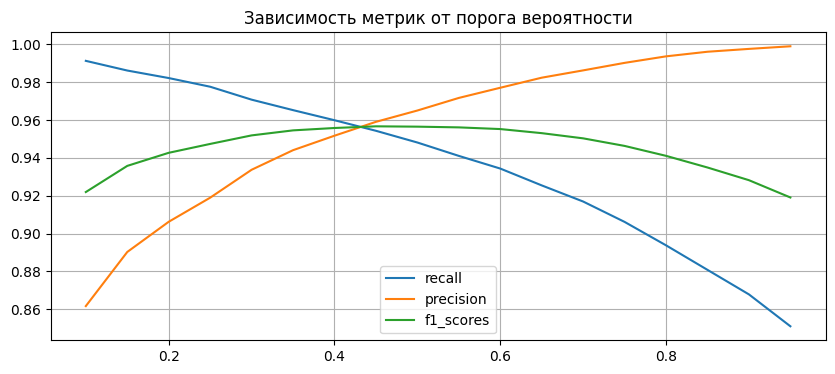

In [ ]:
# Порог принятия решений

# списки, в которых будут значения метрик
recall_scores = []
precision_scores = []
f1_scores = []

# набор вероятностных порогов в диапазоне от 0.1 до 1
thresholds = np.arange(0.1, 1, 0.05)

# В цикле перебирать пороги
for threshold in thresholds:
    preds_new = (preds_proba_new > threshold).astype(int)

    recall_scores.append(metrics.recall_score(y_test, preds_new))
    precision_scores.append(metrics.precision_score(y_test, preds_new))
    f1_scores.append(metrics.f1_score(y_test, preds_new))

fig = plt.figure(figsize=(10, 4))
sns.lineplot(x=thresholds, y=recall_scores, label='recall')
sns.lineplot(x=thresholds, y=precision_scores, label='precision')
sns.lineplot(x=thresholds, y=f1_scores, label='f1_scores')
plt.title('Зависимость метрик от порога вероятности')
plt.legend()
plt.grid(True)
plt.show()

Выбираем порог 0.45 - на пересечении метрик

In [ ]:
#Задаём оптимальный порог вероятностей
threshold_opt = 0.45
preds_opt_new = (preds_proba_new >= threshold_opt).astype('int')
print(classification_report(y_test, preds_opt_new))

              precision    recall  f1-score   support

           0       0.92      0.92      0.92     38648
           1       0.96      0.95      0.96     71950

    accuracy                           0.94    110598
   macro avg       0.94      0.94      0.94    110598
weighted avg       0.94      0.94      0.94    110598



практически одинаковые метрики при порогах 0.5 и 0.45

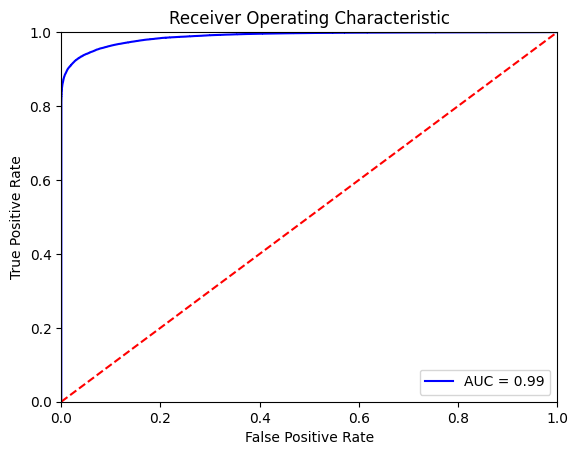

In [ ]:
# Строим ROC кривую из статистики)
fpr, tpr, threshold = metrics.roc_curve(y_test, preds_proba_new)
roc_auc = metrics.auc(fpr, tpr)
plt.title('Receiver Operating Characteristic')
plt.plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc)
plt.legend(loc = 'lower right')
plt.plot([0, 1], [0, 1],'r--')
plt.xlim([0, 1])
plt.ylim([0, 1])
plt.ylabel('True Positive Rate')
plt.xlabel('False Positive Rate')
plt.show()

По факту что сделано
- Чистка данных и удаление пропусков
- Использование TF-IDF для текстового признака name
- Разделение на тренировочную и валидационную выборки (stratify=y_train)
- CatBoost с указанием категориальных признаков (не делал скейлеров)
- Добавление новых признаков (фичей) на основе текстовых данных
- Контроль метрик на валидации (AUC)
- Сравнение результатов до и после добавления новых признаков

результаты
- ROC-AUC ~0.986 → 0.988 после новых признаков — улучшение небольшое
- Precision, recall, f1-score на уровне 0.9+ и с новыми фичами и если не добавлять их такой же в целом, порог вероятности также не сильно влияет (0.45 и 0.5)

что еще тут сделать
- Можно протестить вариант 2й - не удаляем безбожно пропуски, а заменяем на 'unknown'
- пробовать BERT
- запихнуть в реализации все в пайплайны, чтобы выглядело красивее)



# Описание модели для выдачи рекомендаций

Если модель первого уровня определила, что type неверный (==0)
- предсказать наиболее вероятные type — выдать 10 рекомендаций
- многоклассовая классификация (type — класс / таргет)
- обучение происходит только на примерах target = 1 - верных

Логика:
- сначала используем бинарную модель, и если она говорит type неверный
- передаем данные (без type) во вторую модель,
- получаем 10 вероятных классов из неё

Пайплайн
- Модель 1 - Обучаем на всем X_train_full_new → предсказываем target
- Модель 2 - Используем только те строки, где истинный target == 1
- Предсказание
    - используем первую модель, чтобы решить — нужно ли запускать вторую

In [ ]:
print(X_train_full_new.shape)
print(X_test_full_new.shape) # + 10 фичей
print(y_train.shape)
print(y_test.shape)

(442365, 514)
(110598, 514)
(442365,)
(110598,)


In [ ]:
# Отбираем только те строки, где target == 1 - обучаться на верных примерах
X_train_mc = X_train_full_new[y_train == 1].copy()
y_train_mc = data_train.loc[y_train == 1, 'type'].copy()  # целевой признак — type

X_test_mc = X_test_full_new[y_test == 1].copy()
y_test_mc = data_test.loc[y_test == 1, 'type'].copy()  # целевой признак — type

In [ ]:
X_train_mc = X_train_mc.drop(columns=['type'])
X_test_mc = X_test_mc.drop(columns=['type'])

In [ ]:
# Подсчёт частот
type_counts = y_train_mc.value_counts()
# Копия целевого признака
y_train_mc_mod = y_train_mc.copy()
y_test_mc_mod = y_test_mc.copy()

In [ ]:
# заменяем редкие классы на 'Other'
# Порог
threshold = 100
rare_classes = type_counts[type_counts < threshold].index
y_train_mc_mod.loc[y_train_mc_mod.isin(rare_classes)] = 'other'
y_test_mc_mod.loc[y_test_mc_mod.isin(rare_classes)] = 'other'
X_train_mc_mod = X_train_mc.copy()
X_test_mc_mod = X_test_mc.copy()
y_train_mc_mod.value_counts()

type
other                      80647
Картина                    24102
Фотообои                   15614
Матрас                     11911
Постер                      9177
                           ...  
Пуловер                      100
Мокасины                     100
Ремень поликлиновой          100
Инструменты для рыбалки      100
Активные компоненты          100
Name: count, Length: 316, dtype: int64

In [ ]:
# Кодируем метки в числа для обучения модели
train_classes = set(y_train_mc_mod.unique())

# Функция для замены неизвестных классов на 'other'
def replace_labels(series, known_classes):
    return series.apply(lambda x: x if x in known_classes else 'other')
# Применяем к тесту
y_test_mc_mod = replace_labels(y_test_mc, train_classes)

type_encoder = LabelEncoder()
y_train_mc_encoded = type_encoder.fit_transform(y_train_mc_mod)
y_test_mc_encoded = type_encoder.transform(y_test_mc_mod)

In [ ]:
y_train_mc_encoded

array([129,   2,  16, ..., 147,   2,   2], shape=(287790,))

In [ ]:
from sklearn.decomposition import PCA

# Не обучается, не хватает мощностей или что-то не так, продую понизить размерность (категориальные не учитываю)
X_train_mc_pca = X_train_mc.drop(labels=['category_l2', 'category_l4'], axis=1)
X_test_mc_pca = X_test_mc.drop(labels=['category_l2', 'category_l4'], axis=1)

In [ ]:
# Масштабируем признаки для PCA
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train_mc_pca)
X_test_scaled = scaler.transform(X_test_mc_pca)

# PCA — оставим 50 компонент
pca = PCA(n_components=50, random_state=42)
X_train_pca = pca.fit_transform(X_train_scaled)
X_test_pca = pca.transform(X_test_scaled)

In [ ]:
print(f'X_train_pca shape: {X_train_pca.shape}')
print(f'X_test_pca shape: {X_test_pca.shape}')

X_train_pca shape: (287790, 50)
X_test_pca shape: (71950, 50)


In [ ]:
# Разделяем данные на тренировочную и валидационную выборки с стратификацией
X_train_mc_part, X_val_mc, y_train_mc_part, y_val_mc = train_test_split(
    X_train_pca,
    y_train_mc_encoded,
    test_size=0.2,
    random_state=42,
    stratify=y_train_mc_encoded
)
print(f"X_train_mc_part shape: {X_train_mc_part.shape}, X_val_mc shape: {X_val_mc.shape}")

X_train_mc_part shape: (230232, 50), X_val_mc shape: (57558, 50)


In [ ]:
# CatBoost для мультиклассовой классификации
model_mc = CatBoostClassifier(
    iterations=150,                # Максимальное количество деревьев
    learning_rate=0.1,             # Скорость обучения
    depth=6,                       # Максимальная глубина деревьев
    loss_function='MultiClassOneVsAll',    # Функция потерь
    eval_metric='AUC',      # Метрика
    verbose=15,                   # каждые 100 итераций вывод логов
    random_seed=42
)

In [ ]:
# обучаем на тренировочных
model_mc.fit(
    X_train_mc_part,
    y_train_mc_part,         # числовые метки классов
    eval_set=(X_val_mc, y_val_mc), # для контроля переобучения
)

0:	test: 0.8682058	best: 0.8682058 (0)	total: 17.1s	remaining: 42m 31s
15:	test: 0.9883677	best: 0.9883677 (15)	total: 6m 47s	remaining: 56m 55s
30:	test: 0.9904452	best: 0.9904452 (30)	total: 14m 19s	remaining: 54m 58s
45:	test: 0.9925708	best: 0.9925708 (45)	total: 21m 5s	remaining: 47m 40s
60:	test: 0.9945951	best: 0.9945951 (60)	total: 27m 55s	remaining: 40m 45s
75:	test: 0.9963132	best: 0.9963132 (75)	total: 34m 31s	remaining: 33m 36s
90:	test: 0.9973716	best: 0.9973716 (90)	total: 40m 39s	remaining: 26m 21s
105:	test: 0.9978682	best: 0.9978682 (105)	total: 47m 2s	remaining: 19m 31s
120:	test: 0.9982033	best: 0.9982033 (120)	total: 53m 9s	remaining: 12m 44s
135:	test: 0.9984363	best: 0.9984363 (135)	total: 59m 12s	remaining: 6m 5s
149:	test: 0.9986334	best: 0.9986334 (149)	total: 1h 4m 44s	remaining: 0us

bestTest = 0.9986334238
bestIteration = 149



In [ ]:
y_pred_test = model_mc.predict(X_test_pca)

In [ ]:
from sklearn.metrics import accuracy_score, classification_report
# Точность
print("Accuracy на test:", accuracy_score(y_test_mc_encoded, y_pred_test))

Accuracy на test: 0.8326337734537873


## Описание функций

In [ ]:
def prepare_features_for_prediction(user_input):
    """
    Подготавливает признаки
    """
    data = {
        'name': [user_input['name']],
        'type': [user_input.get('type', 'unknown')],
        'category_l2': [user_input.get('category_l2', 'unknown')],
        'category_l4': [user_input.get('category_l4', 'unknown')],
        'is_markup': [int(user_input.get('is_markup', 0))]
    }
    df = pd.DataFrame(data)

    # TF-IDF по названию
    vectorizer_text = vectorizer.transform(df['name'])
    vectorizer_text = pd.DataFrame(vectorizer_text.toarray(), columns=[f'tfidf_{i}' for i in range(vectorizer_text.shape[1])])

    # Объединяем с основными признаками
    df_full = pd.concat([vectorizer_text, df], axis=1)

    # Фичи новые
    df_full['len_name'] = df_full['name'].astype(str).str.len()
    df_full['len_type'] = df_full['type'].astype(str).str.len()
    df_full['len_category_l2'] = df_full['category_l2'].astype(str).str.len()
    df_full['len_category_l4'] = df_full['category_l4'].astype(str).str.len()
    df_full['n_words_name'] = df_full['name'].astype(str).str.split().apply(len)
    df_full['n_words_type'] = df_full['type'].astype(str).str.split().apply(len)
    df_full['n_words_category_l2'] = df_full['category_l2'].astype(str).str.split().apply(len)
    df_full['n_words_category_l4'] = df_full['category_l4'].astype(str).str.split().apply(len)
    df_full['type_in_name'] = df_full.apply(
        lambda row: int(str(row['type']).lower() in str(row['name']).lower()),
        axis=1
    )
    df_full['common_words_name_type'] = df_full.apply(
        lambda row: len(set(str(row['name']).lower().split()) & set(str(row['type']).lower().split())),
        axis=1
    )
    # Удаляем 'name', оставляем 'type', 'category_l2', 'category_l4'
    df_full = df_full.drop(labels='name', axis=1)

    # для model_new (с PCA)
    # Для PCA: удаляем категориальные поля
    df_pca_input = df_full.drop(columns=['type', 'category_l2', 'category_l4'])
    # Масштабирование и PCA
    X_scaled = scaler.transform(df_pca_input)
    X_pca = pca.transform(X_scaled)

    X_mc = df_full.copy()
    return X_pca, X_mc

In [ ]:
def classify_and_recommend(user_input, top_k=10):
    X_pca, X_mc = prepare_features_for_prediction(user_input)

    # подходит ли указанный тип
    proba = model_new.predict_proba(X_mc)[0, 1]
    is_correct = int(proba > 0.5)

    if is_correct:
        return {
            'result': 'Тип указан правильно',
            'probability': round(proba, 3),
            'recommendations': f'оставляем {X_mc["type"].values[0]}'
        }

    # Многоклассовая модель: топ-k рекомендаций
    probs = model_mc.predict_proba(X_pca)[0]
    top_k_indices = probs.argsort()[::-1][:top_k]
    top_k_types = type_encoder.inverse_transform(top_k_indices)
    top_k_scores = probs[top_k_indices]

    recommendations = [{'type': t, 'score': round(s, 3)} for t, s in zip(top_k_types, top_k_scores)]

    return {
        'result': 'Тип, скорее всего, неверный',
        'probability': round(proba, 2),
        'recommendations': recommendations
    }

## Примеры работы модели

In [ ]:
user_input_1 = {
    'name': 'Подвесная люстра Vitaluce V1339/5',
    'type': 'Люстра потолочная',
    'category_l2': 'Строительство и ремонт',
    'category_l4': 'Светильник для дома',
    'is_markup': 0
}
classify_and_recommend(user_input_1)

{'result': 'Тип указан правильно',
 'probability': np.float64(1.0),
 'recommendations': 'оставляем Люстра потолочная'}

In [ ]:
user_input_2 = {
    'name': 'Телефон Samsung',
    'type': 'Авто',
    'category_l2': 'Одежда',
    'category_l4': 'Брюки',
    'is_markup': 1
}
classify_and_recommend(user_input_2)

{'result': 'Тип, скорее всего, неверный',
 'probability': np.float64(0.12),
 'recommendations': [{'type': 'other', 'score': np.float64(0.336)},
  {'type': 'Смартфон', 'score': np.float64(0.123)},
  {'type': 'Расходник для печати', 'score': np.float64(0.018)},
  {'type': 'Пальто пуховое', 'score': np.float64(0.008)},
  {'type': 'Куртка', 'score': np.float64(0.008)},
  {'type': 'Шкаф распашной', 'score': np.float64(0.007)},
  {'type': 'Пальто утепленное', 'score': np.float64(0.007)},
  {'type': 'Комплект одежды', 'score': np.float64(0.005)},
  {'type': 'Костюм спортивный', 'score': np.float64(0.004)},
  {'type': 'Кабель питания', 'score': np.float64(0.004)}]}

In [ ]:
user_input_3 = {
    'name': 'Кроссовки Nike max',
    'type': 'Куртка',
    'category_l2': '',
    'category_l4': 'Брюки',
    'is_markup': 1
}
classify_and_recommend(user_input_3)

{'result': 'Тип, скорее всего, неверный',
 'probability': np.float64(0.07),
 'recommendations': [{'type': 'Кроссовки', 'score': np.float64(0.665)},
  {'type': 'other', 'score': np.float64(0.104)},
  {'type': 'Сникеры', 'score': np.float64(0.08)},
  {'type': 'Кеды', 'score': np.float64(0.03)},
  {'type': 'Брюки спортивные', 'score': np.float64(0.021)},
  {'type': 'Ботинки', 'score': np.float64(0.02)},
  {'type': 'Брюки', 'score': np.float64(0.016)},
  {'type': 'Сапоги', 'score': np.float64(0.012)},
  {'type': 'Пуховик', 'score': np.float64(0.012)},
  {'type': 'Куртка', 'score': np.float64(0.009)}]}

### Обобщение проделанной работы и результаты

**1. Подготовка данных:**
* Загружены трениковочные и тестовые данные.
* Удалены ненужные столбцы (`main_photo`, `stratify_column`).
* Обработаны пропуски в категориальных признаках путем их удаления. Это привело к потере около 42% данных, что является значительным объемом. В качестве альтернативы можно было бы заменить пропуски на 'unknown', что позволило бы сохранить больше данных для обучения.
* Текстовые данные из столбца `name` были векторизованы с помощью TF-IDF, чтобы преобразовать их в числовые признаки.

**2. Построение моделей:**
* **Модель 1 (бинарная классификация):** Была построена модель для определения, является ли указанный `type` правильным (target = 1) или нет (target = 0).
* **Модель 2 (многоклассовая классификация):** Для случаев, когда первая модель предсказывает неверный `type`, была построена вторая модель для рекомендации наиболее вероятных `type`.
    * Обучение второй модели проводилось только на данных, где `target` был равен 1.
    * Для уменьшения количества классов редкие `type` были объединены в один класс 'other'.
    * Для уменьшения размерности и ускорения обучения был применен метод главных компонент (PCA).

**3. Результаты:**
* Точность (Accuracy) на тестовых данных для многоклассовой модели составила ~0.82

**4. Что можно улучшить:**
* **Обработка пропусков:** Вместо удаления строк с пропусками, можно попробовать заменить их на 'unknown' или использовать другие методы для заполнения пропусков. Это позволит сохранить больше данных для обучения.
* **Feature Engineering:** Можно создать больше признаков из существующих данных. Например, можно извлечь бренд из названия товара, создать признаки на основе длины текстовых полей и т.д.
* **Подбор гиперпараметров:** Можно провести более тщательный подбор гиперпараметров для моделей, чтобы улучшить их производительность.
* **Работа с несбалансированными классами:** В данных может быть дисбаланс классов. Можно использовать методы, такие как взвешивание классов или over/under-sampling, чтобы улучшить качество модели.
* **Использование более сложных моделей:** Можно попробовать использовать более сложные модели, такие как нейронные сети, для улучшения качества предсказаний.